In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import itertools
import math
import pickle
import os
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


from utils.config import *
from utils.ortool import *
from utils.Misc import *
from problems import *
from nets import *
from agents import *
from utils import *
from agents import AgentPPO, Actor_Critic


### Plot vehicle routes

In [2]:

def plot_customers(ax, customers, detailed = True):
    r"""
    :param ax:        Axes object to plot to
    :param customers: :math:`L_c \times D_c` tensor containing customers' features
    :param detailed:  Toggle printing features of each customer next to its node
        Default = False
    :type ax:         matplotlib.pyplot.Axes
    :type customers:  torch.Tensor(dtype = torch.float)
    :type detailed:   bool
    """

    ax.axis('equal')
    ax.set_axis_off()
    if detailed:
        ax.set_title("{} customers (Blue:Static, Red:Dynamic)".format(customers.size(0)-1))

    maxdem = customers[1:,3].max().item()
    mindem = customers[1:,3].min().item()
    s = [120+40*(dem-mindem)/(maxdem-mindem+0.2) for dem in customers[1:,3].tolist()]
    cmap = matplotlib.cm.coolwarm

    if customers.size(1) > 3: # Service time
        c = customers[1:,6].tolist()
        cnorm = matplotlib.colors.Normalize(-0.5, 0.5) # service time mean=10, std=2.5 (min)
    else:
        c = [1.0 for _ in customers[1:]]
        cnorm = matplotlib.colors.Normalize(-1, 1)
    
    ax.scatter(*zip(*customers[0:1,:2].tolist()), 200, 'g', 'd')
    ax.scatter(*zip(*customers[1:,:2].tolist()), s, c, 'o', cmap, cnorm)
            
    for j, cust in enumerate( customers.tolist() ):
        ax.text(cust[0],cust[1],str(j), fontsize = 10,
                horizontalalignment = 'center', verticalalignment = 'center')
    return ax

def discrete_cmap(N, base_cmap='ocean'):
    base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data_to_plot, routes_without_depot, markersize = 5):

    fig, ax1 = plt.subplots(1, 1, figsize = (12,10))
    
    depot = data_to_plot[0,:2].cpu().numpy()
    locs = data_to_plot[1:,:2].cpu().numpy()

    x_dep, y_dep = depot
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    legend = ax1.legend(loc='upper center')
    cmap = discrete_cmap(len(routes_without_depot) + 2)

    qvs = []
    total_dist = 0

    for veh_number, r in enumerate(routes_without_depot):
        r = np.array(r)
        color = cmap(len(routes_without_depot) - veh_number)
        coords = locs[r-1, :]
        xs, ys = coords.transpose()

        ax1 = plot_customers(ax1, data_to_plot)

        dist = 0
        x_prev, y_prev = x_dep, y_dep

        for (x, y) in coords:
                dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
                x_prev, y_prev = x, y

        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist

        xs = np.append(xs,x_dep)
        xs = np.insert(xs,0,x_dep)
        ys = np.append(ys,y_dep)
        ys = np.insert(ys,0,y_dep)


        qv = ax1.quiver(
                        xs[:-1],
                        ys[:-1],
                        xs[1:] - xs[:-1],
                        ys[1:] - ys[:-1],
                        scale_units='xy',
                        angles='xy',
                        scale=1,
                        width = 0.004,
                        color=color,
                        label='Route{}, #Customers {},Distance {:.2f}'.format(
                        veh_number, 
                        len(r), 
                        dist))

        qvs.append(qv)

        ax1.set_title('Blue:Static, Red:Dyanamic,{} routes, total distance {:.2f}'.format(len(routes), total_dist))
        ax1.legend(handles=qvs)

In [4]:
args = ParseArguments()
dod = args.dod
customer_count = args.customer_count

data = torch.load("./data/validation/{}/val.pth".format(customer_count))

data_t = data
data_t.normalize()
print(data_t.vehicle_speed)
loader = DataLoader(data_t, batch_size=20, shuffle=False)

learner = Actor_Critic(7,4,10, encoder_layer=4, model_size = 128, ff_size_actor=512,ff_size_critic=512)
checkpoint = torch.load("./output/exp10final_4_1e-05_0.01_230828/epoch1.pth", 
                        map_location = 'cpu')

learner.load_state_dict(checkpoint['model'])
learner.eval()
learner.greedy  = True

4.8


FileNotFoundError: [Errno 2] No such file or directory: './output/exp10final_4_1e-05_0.01_230828/epoch1.pth'

## Plot Customers and Routes

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.66it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_46099/538239874.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_46099/538239874.py:38: Matplotli

[[7, 6, 10, 9, 1, 2], [4, 8, 3, 5]]
[[8, 9, 6, 3, 10], [4, 7, 1, 5, 2]]
[[6, 10, 1, 5], [7, 2, 4, 3, 9, 8]]
[[3, 10, 7, 4], [6, 8, 2, 5, 1, 9]]
[[6, 10, 7, 4, 8, 5], [2, 9, 3, 1]]
[[4, 1, 5, 3, 6, 8], [2, 9, 7, 10]]
[[5, 6, 3, 8], [9, 4, 7, 1, 10, 2]]
[[1, 8, 7, 10, 2, 6], [4, 3, 9, 5]]
[[8, 6, 10, 1, 4, 9, 7], [3, 5, 2]]
[[3, 2, 4, 6], [1, 8, 7, 9, 10, 5]]


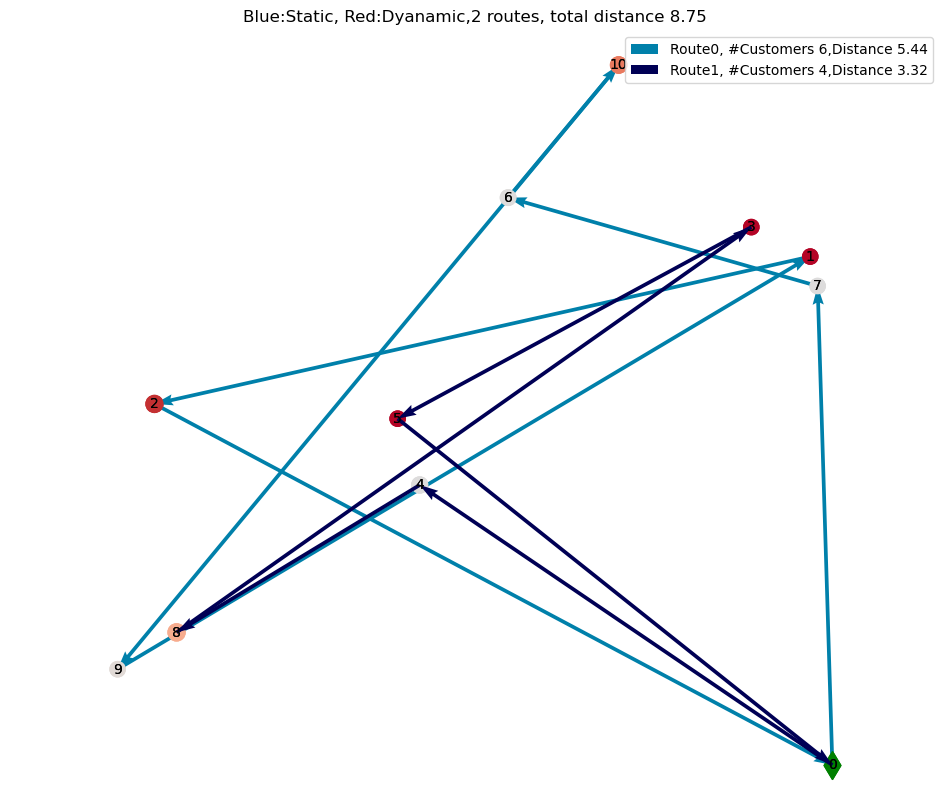

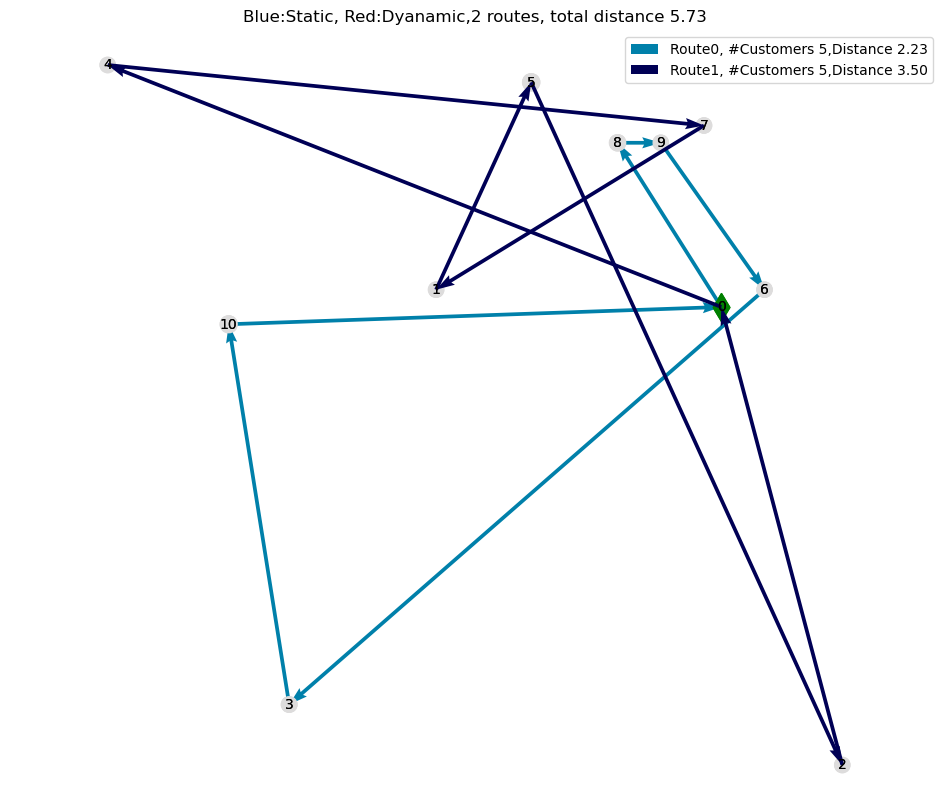

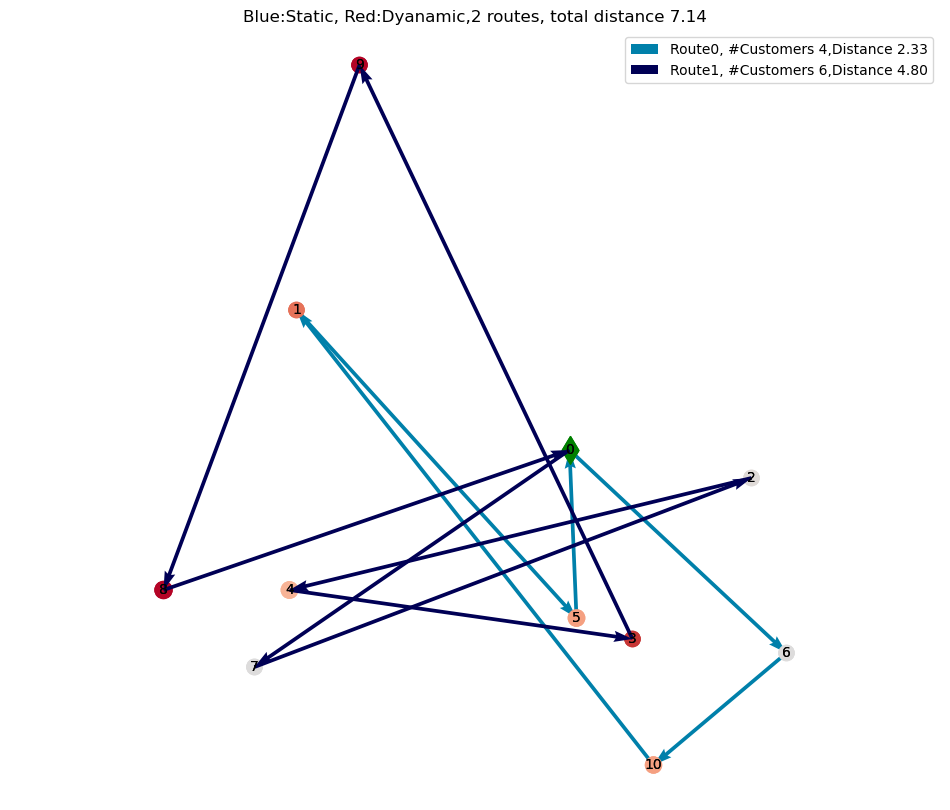

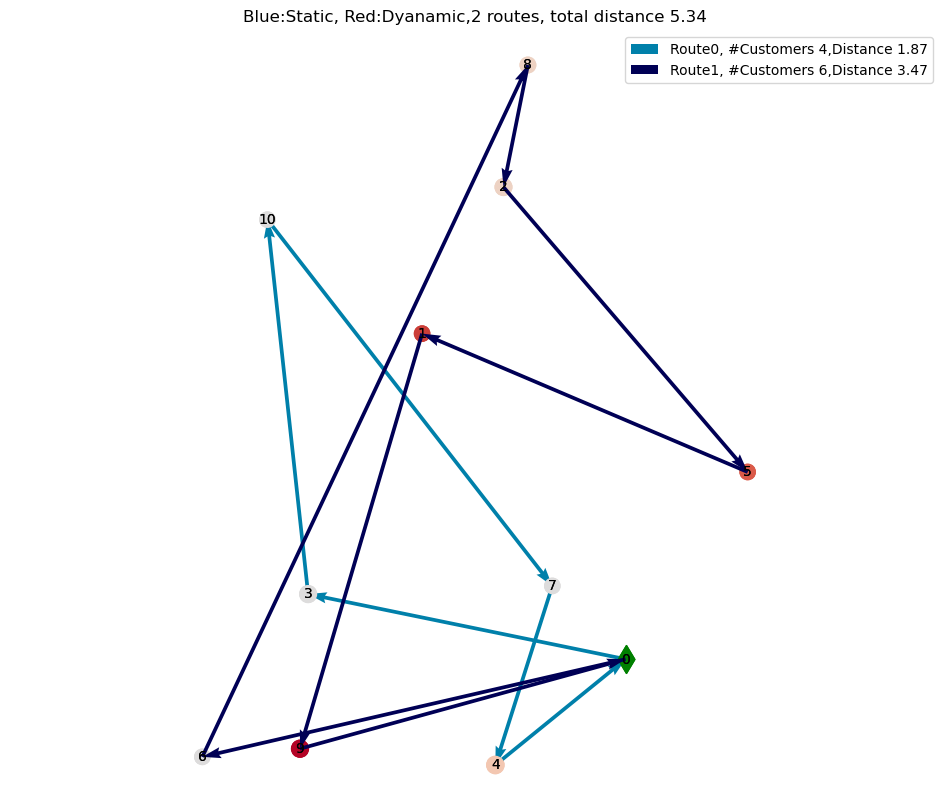

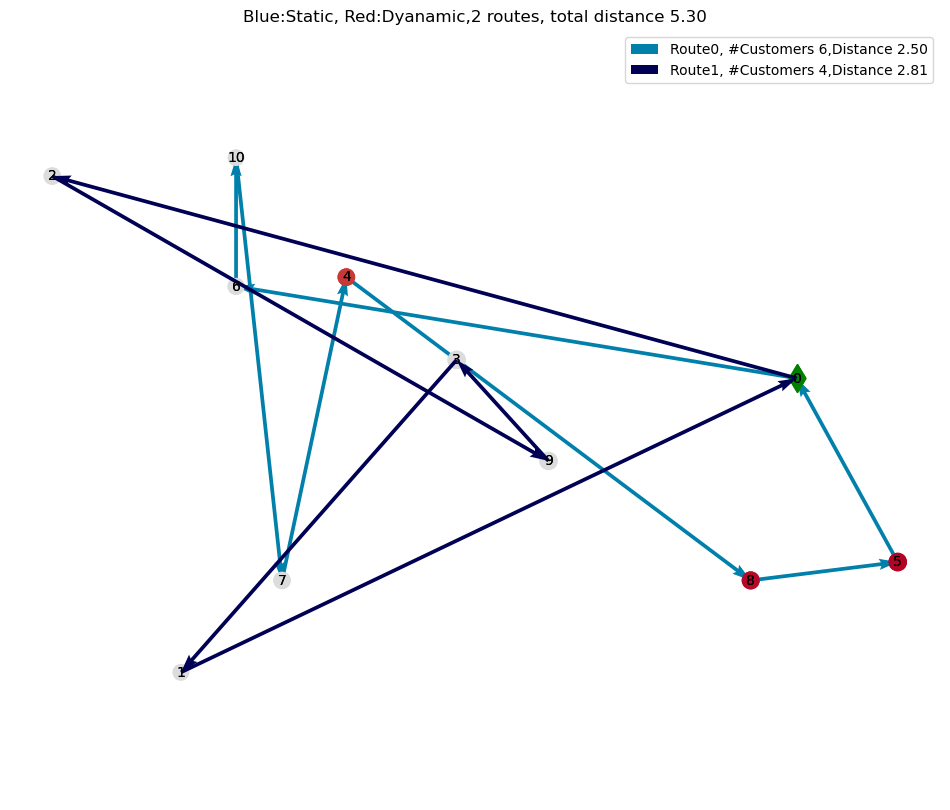

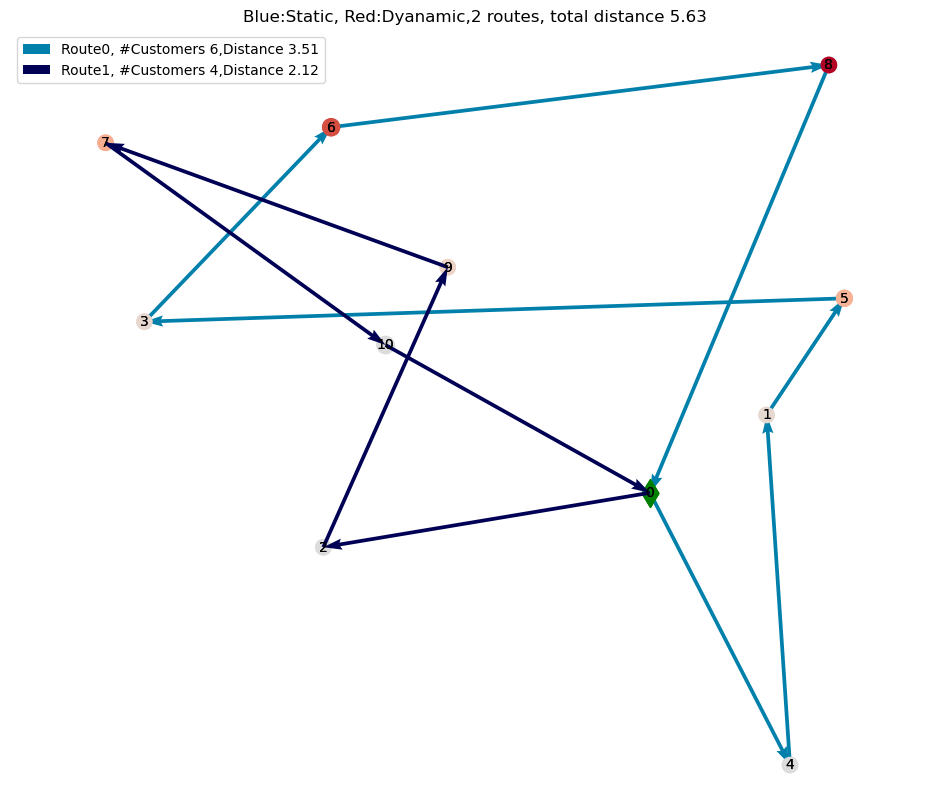

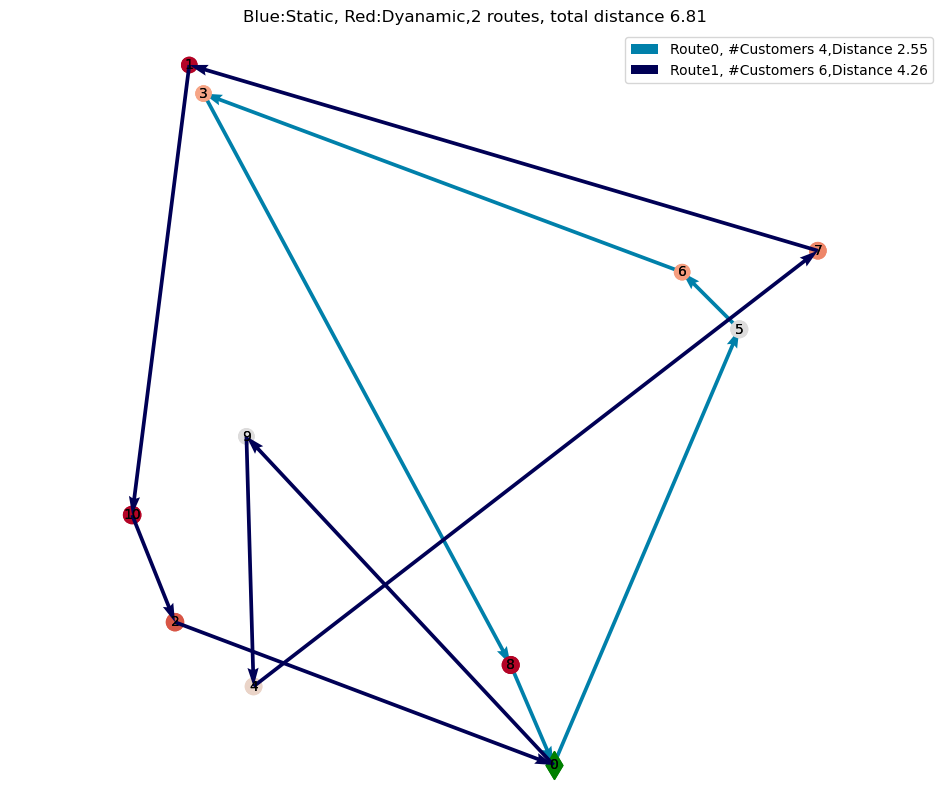

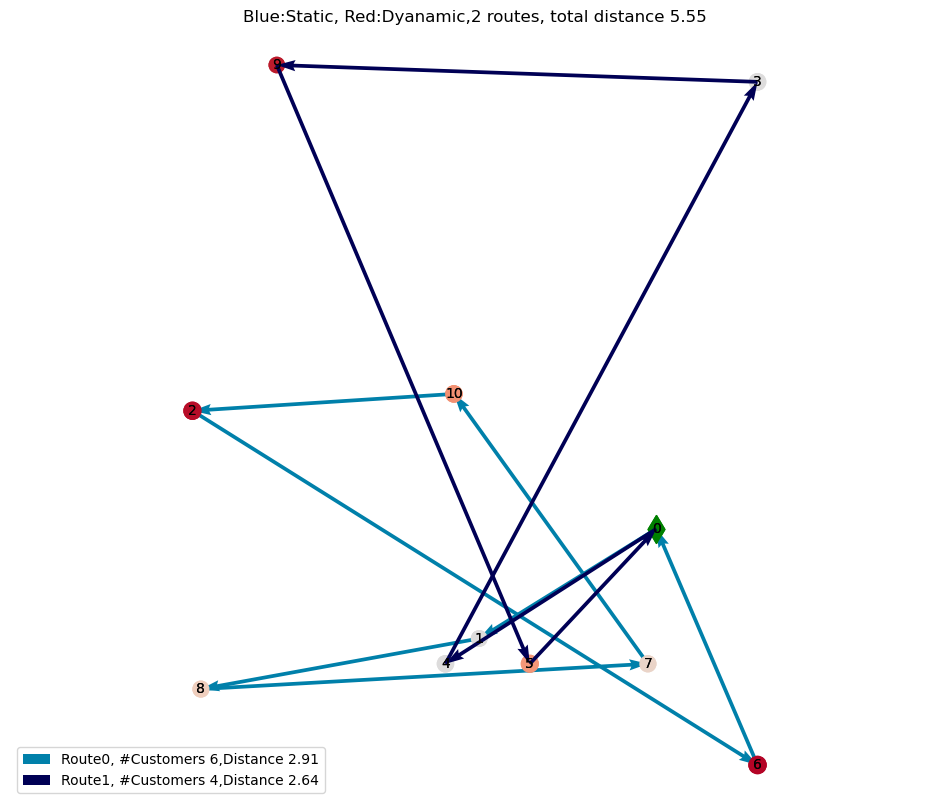

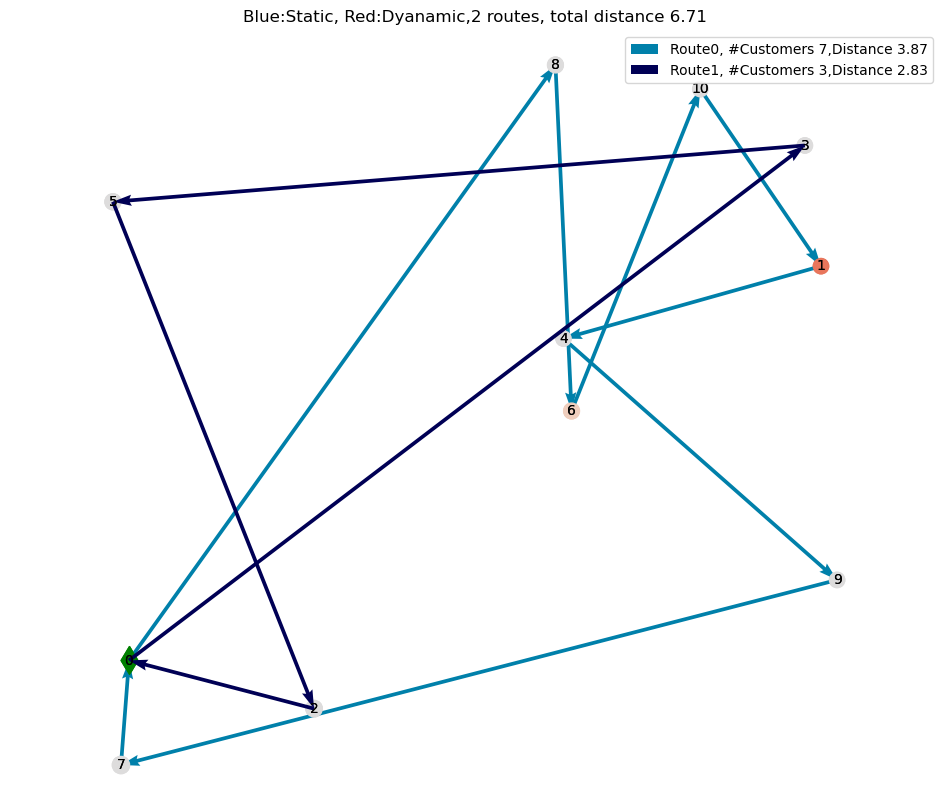

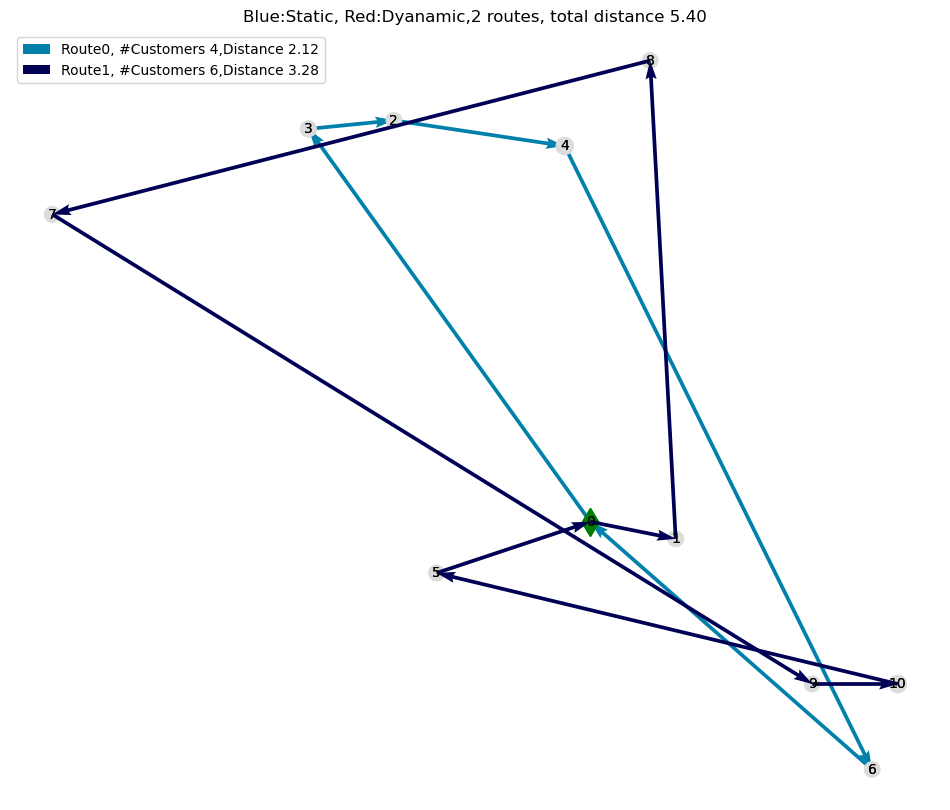

In [27]:
agent_actions = []
with torch.no_grad():
    for _, minibatch in enumerate(tqdm(loader)):
        env = DSVRPTW_Environment(data = data_t, pending_cost=0, late_cost=0)
        actions,logps, rewards,_ = learner.act(env)
        #print(minibatch[0])
        #print(env.vehicles)
        #print(env.nodes)
        #print(actions)
        
        agent_actions.append(actions)
        
# Convert tensor to array
agent_actions_to_array = np.array([[[t[0][i].item(), t[1][i].item()] 
                                    for i in range(len(t[0]))] 
                                    for t in agent_actions[0]])
tours = []

for i in range(len(agent_actions_to_array[0])):
    temp = []
    for j in range(len(agent_actions_to_array)):
        temp.append(agent_actions_to_array[j][i])
    tours.append(temp)


for i, (data, tour) in enumerate(zip(env.nodes, tours)):
    
    tour = pd.DataFrame(tour)
    tour.columns = ['vehicles','customers']  
    
    # Create a grouping column
    tour['group'] = tour.groupby('vehicles').cumcount()

    # Reshape the DataFrame
    tour = tour.pivot(index='group', columns='vehicles', values='customers')

    # Rename the columns
    column_names = [f'vehicles_{val}' for val in tour.columns]
    tour.columns = column_names
    tour = tour.fillna(0).astype(int)

    routes = []
    for vehicle_name in list(tour.columns):
        routes.append(list(tour[vehicle_name]))

    routes_without_depot = []
    for route in routes:
        r = [cust for cust in route if cust!=0]
        routes_without_depot.append(r)
        
    print(routes_without_depot)
    if ((len(routes_without_depot[0]) >= 0 ) or (len(routes_without_depot[0]) >= 0)):
        plot_vehicle_routes(data, routes_without_depot)
    

## Quality of Service (QOS)

In [29]:
data = torch.load("./data/validation/{}/val.pth".format(customer_count))

data_t = data
data_t.normalize()
print(data_t.vehicle_speed)
loader = DataLoader(data_t, batch_size=20, shuffle=False)

learner = Actor_Critic(7,4,10, encoder_layer=3, model_size = 128, ff_size_actor=512,ff_size_critic=512)
checkpoint = torch.load("./output/exp10_entropy0.01_10_230825/epoch1.pth", 
                        map_location = 'cpu')

learner.load_state_dict(checkpoint['model'])
learner.eval()
learner.greedy  = True

costs = []
QOS = []

with torch.no_grad():
    for _, minibatch in enumerate(tqdm(loader)):
        env = DSVRPTW_Environment(data = data_t, pending_cost=0, late_cost=0)
        actions,_, rewards,_ = learner.act(env)
        costs.append(torch.stack(rewards).sum(dim=0).squeeze(-1))  
        
        # Calaculate Quality of Service:
        pending = (env.served ^ True).float().sum(-1) - 1
        QOS.append(1 - pending / (env.nodes_count - 1))

        
        
    costs = torch.cat(costs, 0)
    QOS = torch.cat(QOS, 0)
    
dods = (data.nodes[:,:,6] > 0).sum(1).float() / (data.nodes.size(1)-1)

for k,subset in (("leq00", dods == 0.0),
                 ("leq40", (dods <= 0.4)),
                 ("less60", (0.4 < dods) & (dods < 0.6)),
                 ("geq60", 0.6 <= dods)):
    
    print("{}: {:5.2f} +- {:5.2f} (qos={:.2%})".format(k, 
                                                       costs[subset].mean(), 
                                                       costs[subset].std(),
                                                       QOS[subset].mean()))


4.8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.30it/s]

leq00:  5.42 +-  0.04 (qos=100.00%)
leq40:  5.75 +-  0.40 (qos=100.00%)
less60:   nan +-   nan (qos=nan%)
geq60:  6.72 +-  1.02 (qos=100.00%)
